In [3]:
import numpy as np
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import json
import pydde as dde
import os

########################################
#PARAMETERS
nTimeSteps = 30; #seconds
hiddenlayers = [100]
samples_per_file = 1000
data_file_path = '../Data/Samples/data_1x1_30t/'
criterion = nn.SmoothL1Loss()  # Huber Loss
model_file_path = '../Trained_Models/Model_latest.pt'
model_statedict_file_path = '../Trained_Models/state_dict/Model_statedict_active_latest.pt'
simulation_file_path = '../Data/Simulations/pointmass.sim'
objective_file_path = "../Data/Objectives/pointmass.opt"

#########################################
#LOAD SAMPLES
number_of_files = len(os.listdir(data_file_path))-1
number_of_samples = samples_per_file*number_of_files
p = np.zeros((3*nTimeSteps, number_of_samples))
y_target = np.zeros((number_of_samples, 3))
gradnorm_truth = np.zeros(number_of_samples)
iterations_truth = np.zeros(number_of_samples)
loss_truth  = np.zeros(number_of_samples)

for filenum in range(number_of_files):
    with open(data_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['y_target'])
        for i, p_i in enumerate(data['parameter']):
            p[:, filenum*filesize+i] = np.array(p_i)
        for s, y_s in enumerate(data['y_target']):
            y_target[filenum*filesize+s, :] = np.array(y_s)
        for i, truth in enumerate(data['loss']):
            loss_truth[filenum*filesize+i] = np.array(truth)
        for i, truth in enumerate(data['iterations']):
            iterations_truth[filenum*filesize+i] = np.array(truth)
        for i, truth in enumerate(data['loss']):
            gradnorm_truth[filenum*filesize+i] = np.array(truth)
p = p.transpose()
print(f'Shape of y_target: {y_target.shape}')
print(f'Shape of p: {p.shape}')

y_test = torch.tensor(y_target).float()
p_test = torch.tensor(p).float()

#########################################
#LOAD MODEL
class PassiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(PassiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, hiddenlayers[0])
        self.H1 = nn.Linear(hiddenlayers[0], 3*nTimeSteps)
        self.L_out = nn.Linear(3*nTimeSteps, 3*nTimeSteps)
        self.Relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=0.5)
    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        x = self.Relu(x)
        x = self.L_out(x)
        return x

model = PassiveLearn(3, 180)
model.load_state_dict(torch.load(model_statedict_file_path))
#model = torch.load(model_file_path)

#########################################
#TEST THE DATA
losses_test= []
with torch.no_grad():
    for i in range(number_of_samples):
        p_val = model(y_test[i, :])
        loss = criterion(p_val,p_test[i,:])
        losses_test.append(loss.clone().numpy())#Test the data

Shape of y_target: (10000, 3)
Shape of p: (10000, 90)


## PLOTS

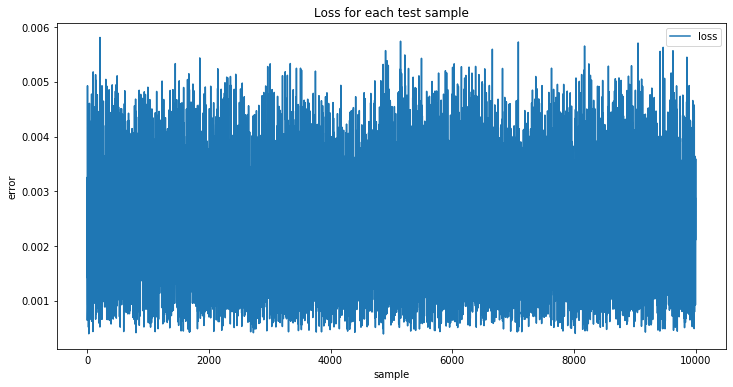

23.555972873291466


In [4]:
#########################################
#Plot loss for each test sample
plt.figure(figsize = [12,6])
loss_test = plt.plot(losses_test, label = 'loss')
plt.legend()
plt.ylabel('error')
plt.xlabel('sample')
plt.title('Loss for each test sample')
plt.show()
tot_error = sum(losses_test)
print(tot_error)

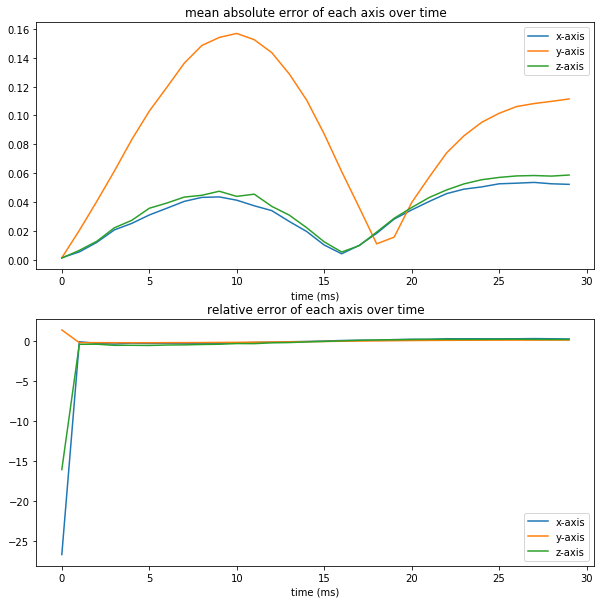

In [6]:
#########################################
#Calculte relative and absolute error
rel_errors_norm = []
with torch.no_grad():
    for i in range(number_of_samples):
            p_val = model(y_test[i, :])
            p_truth = p_test[i,:]
            rel_error = np.linalg.norm((p_val - p_truth)/p_truth)
            rel_errors_norm.append(rel_error)

rel_errors_sum = torch.zeros(3*nTimeSteps)
abs_errors_sum = torch.zeros(3*nTimeSteps)
with torch.no_grad():
    for i in range(number_of_samples):
            p_val = model(y_test[i, :])
            p_truth = p_test[i,:]
            rel_error = (p_val - p_truth)/p_truth
            abs_error = np.abs(p_val - p_truth)
            rel_errors_sum = rel_errors_sum + rel_error
            abs_errors_sum = abs_errors_sum + abs_error
x_err_rel = rel_errors_sum[0::3]/(number_of_samples)
y_err_rel = rel_errors_sum[1::3]/(number_of_samples)
z_err_rel = rel_errors_sum[2::3]/(number_of_samples)

x_err = abs_errors_sum[0::3]/(number_of_samples)
y_err = abs_errors_sum[1::3]/(number_of_samples)
z_err = abs_errors_sum[2::3]/(number_of_samples)

#########################################
#Calculte relative error
plt.figure(figsize = [10,10])
#plt.suptitle('Errors using 5000 samples', fontsize=16)

plt.subplot(2, 1, 2)
plt.plot(x_err_rel, label = 'x-axis')
plt.plot(y_err_rel, label = 'y-axis')
plt.plot(z_err_rel, label = 'z-axis')
plt.xlabel('time (ms)')
plt.title('relative error of each axis over time')
plt.legend()

plt.subplot(2, 1, 1)
plt.plot(x_err, label = 'x-axis')
plt.plot(y_err, label = 'y-axis')
plt.plot(z_err, label = 'z-axis')
plt.xlabel('time (ms)')
plt.title('mean absolute error of each axis over time')
plt.legend()
plt.show()

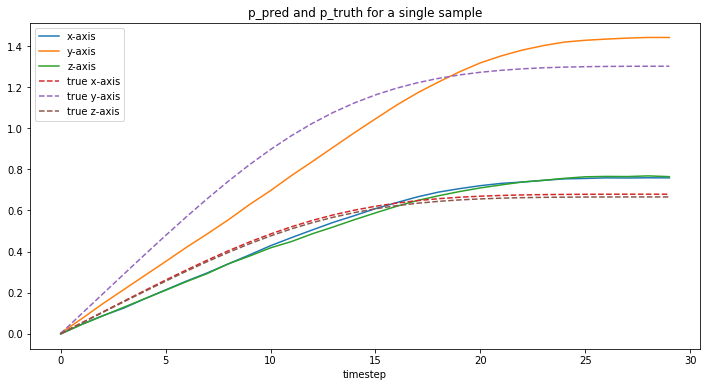

In [7]:
#############################################
#PLOT P_PRED AND P_TRUTH FOR SINGLE SAMPLE
randomsample = 9
with torch.no_grad():
        p_val = model(y_test[randomsample, :])
        p_truth = p_test[randomsample,:]
        x_val = p_val[0::3]
        y_val = p_val[1::3]
        z_val = p_val[2::3]
        x_truth = p_truth[0::3]
        y_truth = p_truth[1::3]
        z_truth = p_truth[2::3]
            

plt.figure(figsize = [12,6])
plt.plot(x_val, label = 'x-axis')
plt.plot(y_val, label = 'y-axis')
plt.plot(z_val, label = 'z-axis')
plt.plot(x_truth, '--', label = 'true x-axis')
plt.plot(y_truth, '--', label = 'true y-axis')
plt.plot(z_truth, '--', label = 'true z-axis')
plt.title('p_pred and p_truth for a single sample')
plt.xlabel('timestep')
plt.legend()
plt.savefig('testfig.png')
plt.show()

In [8]:
#####################################################
#TEST THE MODEL

# Generate simulation
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(0,nTimeSteps):
	p_init[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init)
r = dyn.r(state_init, p_init)
dr = dyn.dr_dp(state_init, p_init)
dq = dyn.dq_dp(state_init, p_init)

#Load objective
obj = dde.InverseObjective(dyn)

#obj.loadFile(objective_file_path)
data = json.load(open(objective_file_path))
data['objectives']['pmTargetPositions'][0]['targetPos'] = ([[0.5],[0.5],[0.5]])
obj.loadJson(data)

y_target_test_= torch.tensor([0.5, 0.5, 0.5])
p_ = model(y_target_test_)
p_ = p_.detach().numpy()
newton = dde.Newton()
p_truth_ = newton.minimize(obj, p_init)
y_target_ = y_target_test_.detach().numpy()

yTraj_test_ = dyn.q(p_)
yTraj_truth_ = dyn.q(p_truth_)

print('TEST OF THE MODEL')
print(f'\ntest for y_target:\n {y_target_test_}')
print(f'\nevaluated y_end:\n {yTraj_test_.q[-3:]}')
print(f'\nsimulated traj_opt y_end with p_truth:\n {yTraj_truth_.q[-3:]}')
print(f'\ndifference of y_end:\n {np.sum(yTraj_test_.q[-3:]-y_target_)}')
print(f'\nlast 6 entries of p predicted:\n {p_[-6:].transpose()}')
print(f'\nlast 6 entries of p from traj_opt:\n {p_truth_[-6:].transpose()}')

TEST OF THE MODEL

test for y_target:
 tensor([0.5000, 0.5000, 0.5000])

evaluated y_end:
 [0.49970698 0.50744781 0.50317873]

simulated traj_opt y_end with p_truth:
 [0.49560763 0.49293486 0.49560763]

difference of y_end:
 0.010333520516868255

last 6 entries of p predicted:
 [0.5313048  1.3313179  0.54336655 0.5331428  1.3346446  0.54357904]

last 6 entries of p from traj_opt:
 [0.47875592 1.21774452 0.47875592 0.478775   1.21785194 0.478775  ]
